##Finding connected components using Python

For undirected graphs, the networkx function number_connected_components() returns the number of connected components in the graph, while the connected_components() function returns the vertices in each connected component.



For directed graphs, similar functions identify weakly and strongly connected components. Let’s use the reported friendships from the schoolfriends data set as an example.

In [1]:
import pandas as pd
import networkx as nx

# get schoolfriends edgelist
schoolfriends_edges = pd.read_csv(
  "https://ona-book.org/data/schoolfriends_edgelist.csv"
)

# use only reported friendships
schoolfriends_reported = schoolfriends_edges[
  schoolfriends_edges.type == "reported"
]

# create directed graph
schoolfriends_rp = nx.from_pandas_edgelist(
  schoolfriends_reported,
  source = "from",
  target = "to",
  create_using=nx.DiGraph
)

# number of weakly connected components
nx.number_weakly_connected_components(schoolfriends_rp)

3

In [2]:
# create component subgraphs 
components = nx.weakly_connected_components(schoolfriends_rp)

subgraphs = [schoolfriends_rp.subgraph(component).copy() 
for component in components]

# size of subgraphs
[len(subgraph.nodes) for subgraph in subgraphs]

[128, 3, 3]

In [3]:
# view nodes in one of the smaller components
subgraphs[2].nodes

NodeView((366, 1485, 974))

##Partitioning and community detection using Python

networkx has numerous algorithmic functions for exploring edge cuts on graphs, including to find the minimum edge cut. You can consult the reference documentation to learn about the various functions available. Let’s use the karate data set to demonstrate how to find a minimum cut.

In [4]:
# get karate edgelist
karate_edges = pd.read_csv("https://ona-book.org/data/karate.csv")

# create undirected network
karate = nx.from_pandas_edgelist(karate_edges, source = "from", 
target = "to")

# find minimum cut
nx.minimum_edge_cut(karate)

{('Actor 12', 'Mr Hi')}

In [5]:
# get minimum edge cut size
len(nx.minimum_edge_cut(karate))

1

Various built-in community detection algorithms are available in the networkx.community module, such as the Girvan-Newman edge betweenness algorithm. This generates communities by progressively removing edges with the highest edge betweenness centrality. It returns an iterator object where the first element is the result of the first edge removal, and subsequent elements are the result of progressive edge removal.

In [6]:
# get communities based on girvan-newman and sort by no of communities
communities = sorted(
  nx.community.girvan_newman(karate), 
  key = len
)

# view communities from first edge removal
pd.DataFrame(communities[0]).transpose()

,0,1
0,Actor 7,Actor 28
1,Mr Hi,Actor 23
2,Actor 20,Actor 31
3,Actor 6,Actor 25
4,Actor 13,Actor 15
5,Actor 2,Actor 27
6,Actor 4,Actor 16
7,Actor 11,Actor 9
8,Actor 12,Actor 24
9,Actor 5,Actor 32


We see that the first split leads to two communities, one around John A and the other around Mr Hi.

The cdlib package in Python contains a very wide range of community detection algorithms that work with the networkx package, including the Louvain and Leiden algorithms as well as many others. In this example, we create a Louvain partition of the karate graph using cdlib.

In [7]:
!pip install cdlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 228 kB 27.9 MB/s 
     |████████████████████████████████| 2.6 MB 43.5 MB/s 
     |████████████████████████████████| 14.2 MB 41.6 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 3.1 MB 38.3 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395122 sha256=175bcb094168f16bbbedf923404408454f21bddc0a28c0700abd48cf52eeaa15
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
  Created wheel for python-igraph: filename=python_igraph-0.9.11-py3-none-any.whl size=9074 sha256=d4f7d9fe88d4e536b2bdce7fb163c65cff02c3a61d017becd8b3c088795b1c14
  Stored in directory: /root/.cache/pip/wheels/7d/e4/0c/0c83f70bd0b99ce8aea47a21f8e52502169e7dd17808d12f30
  Created wheel for python-Levenshtein: filename=python_Levenshtein

In [8]:
from cdlib import algorithms
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt 

# get louvain partition which optimizes modularity
louvain_comms = algorithms.louvain(karate)

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'graph_tool', 'karateclub', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'leidenalg'}


louvain_comms is a clustering object that has a lot of useful properties and methods. To see the communities, use the following:

In [9]:
pd.DataFrame(louvain_comms.communities).transpose()

,0,1,2,3
0,Actor 9,Mr Hi,Actor 5,Actor 32
1,Actor 31,Actor 2,Actor 6,Actor 29
2,Actor 28,Actor 3,Actor 7,Actor 26
3,Actor 33,Actor 4,Actor 11,Actor 25
4,John A,Actor 8,Actor 17,None
5,Actor 15,Actor 12,None,None
6,Actor 16,Actor 13,None,None
7,Actor 19,Actor 14,None,None
8,Actor 21,Actor 18,None,None
9,Actor 23,Actor 20,None,None


We see four communities. The modularity of the resulting community structure can be calculated using the newman_girvan_modularity() method.

In [10]:
louvain_comms.newman_girvan_modularity()

FitnessResult(min=None, max=None, score=0.4155982905982906, std=None)

To visualize the network community structure, we can create a color mapping against the communities

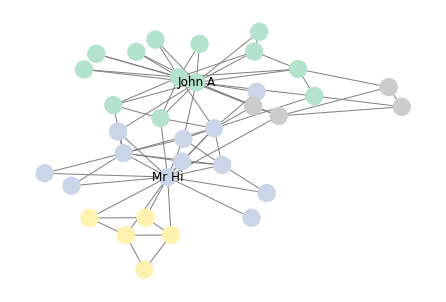

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# create dict with labels only for Mr Hi and John A
node = list(karate.nodes)
labels = [i if i == "Mr Hi" or i == "John A" else "" \
for i in karate.nodes]
nodelabels = dict(zip(node, labels))

# create and order community mappings
communities = louvain_comms.to_node_community_map()
communities = [communities[k].pop() for k in node]

# create color map
pastel2 = cm.get_cmap('Pastel2', max(communities) + 1)

# visualize
np.random.seed(123)
nx.draw_spring(karate, labels = nodelabels, cmap = pastel2,
node_color = communities, edge_color = "grey")
plt.show()

##Finding cliques in Python


All maximal cliques in a graph can be calculated using the find_cliques() function:



In [12]:
cliques = nx.find_cliques(karate)
maximal_cliques = sorted(cliques, key = len)

# get number of maximal cliques
len(maximal_cliques)

36

In [13]:
# get largest clique
maximal_cliques[len(maximal_cliques) - 1]

['Mr Hi', 'Actor 2', 'Actor 4', 'Actor 3', 'Actor 8']

Alternatively, there are functions that can calculate the number of cliques, the size of the largest clique, and can extract the graph of the largest clique.

In [14]:
nx.graph_number_of_cliques(karate)

36

In [15]:
nx.graph_clique_number(karate)

5

#Examples of uses


In this section we will illustrate the implementation and interpretation of community detection algorithms using our Facebook schoolfriends example, and introducing a new example related to political tweets in the Ontario province of Canada.

##Detecting communities and cliques among Facebook friends

Let’s reload our Facebook schoolfriends graph and remove any isolates so that we can investigate communities and cliques inside it.

In [16]:
schoolfriends_edgelist = pd.read_csv("https://ona-book.org/data/schoolfriends_edgelist.csv")
schoolfriends_vertices = pd.read_csv("https://ona-book.org/data/schoolfriends_vertices.csv")

# use only facebook friendships
schoolfriends_facebook = schoolfriends_edges[
  schoolfriends_edges.type == "facebook"
]

# create undirected graph
schoolfriends_fb = nx.from_pandas_edgelist(
  schoolfriends_facebook,
  source = "from",
  target = "to"
)

node_attr = schoolfriends_vertices.set_index('id').to_dict(orient = 'index')
nx.set_node_attributes(G = schoolfriends_fb, values = node_attr)

In [17]:
len(schoolfriends_fb)

156

In [18]:
# remove isolates
isolates = [i for i in schoolfriends_fb.nodes if nx.degree(schoolfriends_fb)[i] == 0]
schoolfriends_fb.remove_nodes_from(isolates)

In [19]:
len(schoolfriends_fb.nodes)

156

We now have a connected, undirected graph of 156 vertices, with class and gender as vertex properties. First, let’s detemine the largest clique in the graph.

In [20]:
max_clique_len = max(map(len, list(nx.find_cliques(schoolfriends_fb))))
[i for i in list(nx.find_cliques(schoolfriends_fb)) if len(i) == max_clique_len]

[[525, 797, 769, 1218, 376, 325, 841, 1423, 466, 245, 440, 694, 125, 638],
 [1067, 1423, 1218, 1237, 376, 440, 841, 624, 466, 245, 125, 638, 325, 694],
 [1067, 1423, 1218, 797, 376, 440, 841, 624, 466, 245, 125, 638, 325, 694],
 [564, 245, 624, 769, 1218, 376, 841, 440, 1423, 466, 1237, 125, 325, 694],
 [624, 440, 769, 1218, 841, 376, 1423, 466, 245, 125, 325, 694, 638, 1237],
 [624, 440, 769, 1218, 841, 376, 1423, 466, 245, 125, 325, 694, 638, 797]]

We see 6 cliques of 14 individuals, all of which have considerable overlap. We can take a look at the class and gender of one of these cliques.

In [21]:
# subgraph for clique 0 (their 6 is our 0)
clique0 = schoolfriends_fb.subgraph([i for i in list(nx.find_cliques(schoolfriends_fb)) if len(i) == max_clique_len][0])
schoolfriends_vertices.loc[schoolfriends_vertices.id.isin(list(clique0.nodes))]

,id,class,gender
111,466,MP*1,M
122,376,MP*1,M
123,638,MP*1,M
129,841,MP*1,M
147,1423,MP*2,M
169,1218,MP*2,M
195,769,PSI*,M
196,797,PSI*,F
202,440,PSI*,F
205,125,PSI*,F


We see that this clique is distributed over four classes and is mostly male. Let’s visualize where this clique sits in the full network

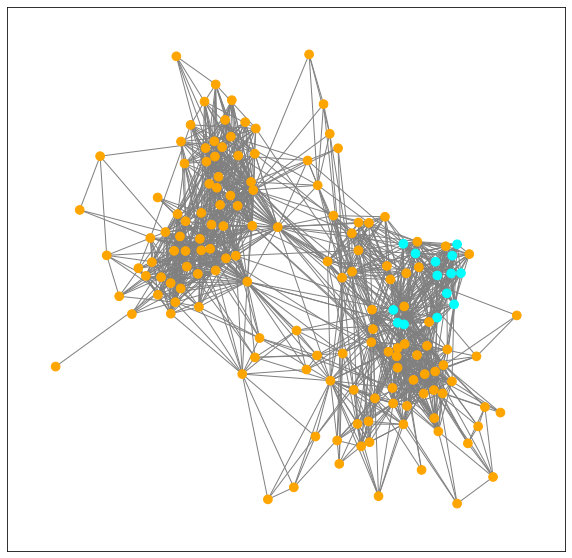

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
nx.draw_networkx(schoolfriends_fb,
                 node_color = ['cyan' if i in clique0.nodes else 'orange' 
                              for i in schoolfriends_fb.nodes],
                 labels = {i:''
                           for i in clique0.nodes},
                 node_shape = '.',
                 edge_color = 'grey')

Now let’s use the Louvain algorithm to detect communities in our graph.



In [23]:
louvain = algorithms.louvain(schoolfriends_fb)
len(louvain.communities)

6

Six communities have been identified. Let’s compare the modularity of this community structure to the known ground truth communities of class and gender.



In [24]:
import networkx.algorithms.community as nx_comm

# modularity of louvain
nx_comm.modularity(schoolfriends_fb, communities = louvain.communities)

0.5290014038951675

In [25]:
# modularity of class structure
df_attr_fb = pd.DataFrame.from_dict(dict(schoolfriends_fb.nodes(data=True)), orient='index')
class_comm = [list(df_attr_fb[df_attr_fb['class'] == i].index.values) 
              for i in df_attr_fb['class'].unique()]
nx_comm.modularity(schoolfriends_fb, communities = class_comm)

0.3171280053114599

In [26]:
# modularity of gender structure
gender_comm = [list(df_attr_fb[df_attr_fb['gender'] == i].index.values) 
              for i in df_attr_fb['gender'].unique()]
nx_comm.modularity(schoolfriends_fb, communities = gender_comm)

0.06504431785658762

This community structure is certainly a better indicator of connected Facebook subgroups than gender or class. We can visualize the class structure side-by-side with the Louvain community structure to try to interpret it

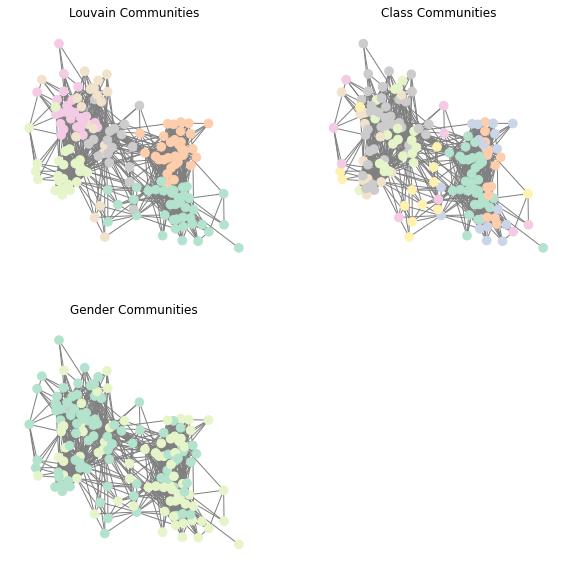

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

# plot louvain commnunities
plt.subplot(221)
communities = louvain.to_node_community_map()
communities = [communities[k].pop() for k in schoolfriends_fb.nodes]
pastel2 = cm.get_cmap('Pastel2', max(communities) + 1)

np.random.seed(123)
plt.title("Louvain Communities")
nx.draw_spring(schoolfriends_fb, with_labels = False, cmap = pastel2,
               node_shape = '.',
               node_color = communities, edge_color = "grey")

# plot class communities
plt.subplot(222)
cls = {k:j for (j,i) in enumerate(class_comm) for k in i}
cls = [cls[k] for k in schoolfriends_fb.nodes]
pastel2 = cm.get_cmap('Pastel2', max(cls) + 1)

np.random.seed(123)
plt.title('Class Communities')
nx.draw_spring(schoolfriends_fb, with_labels = False, cmap = pastel2,
               node_shape = '.',
               node_color = cls, edge_color = "grey")

# plot gender communities
plt.subplot(223)
gdr = {k:j for (j,i) in enumerate(gender_comm) for k in i}
gdr = [gdr[k] for k in schoolfriends_fb.nodes]
pastel2 = cm.get_cmap('Pastel2', max(gdr) + 1)

np.random.seed(123)
plt.title('Gender Communities')
nx.draw_spring(schoolfriends_fb, with_labels = False, cmap = pastel2,
               node_shape = '.',
               node_color = gdr, edge_color = "grey")

Visually, we can see that the Louvain community structure is a much better representation of dense friendship groups compared to the ground truth class structure, indicating that Facebook friendships tend to span across those class structures. We can also see that one of the Louvain communities contains the clique we identified earlier.



## Detecting politically aligned communities on Twitter

The ontariopol_edgelist and ontariopol_vertices data sets represent tweeting activity between Ontario province politicians in Canada as captured in September 2021 and spanning several prior years of activity. Although the Twitter graph is a directed graph, we will set this network up as undirected, with two politicians connected if there has been an interaction between them by means of one mentioning the other in a tweet or one replying to a tweet from the other. The weight property represents the number of interactions and is therefore a measure of the connection strength.



In [60]:
ontariopol_edges = pd.read_csv('https://ona-book.org/data/ontariopol_edgelist.csv')
ontariopol_vertices = pd.read_csv('https://ona-book.org/data/ontariopol_vertices.csv')

# create undirected graph
ontariopol = nx.from_pandas_edgelist(
  ontariopol_edges,
  source = "from",
  target = "to",
  edge_attr = True
)

node_attr = ontariopol_vertices.set_index('id').to_dict(orient = 'index')
nx.set_node_attributes(G = ontariopol, values = node_attr)

We have an undirected, weighted graph, with screen_name and party vertex properties. First, we check if our graph is connected:



In [53]:
nx.is_connected(ontariopol)

True

Now we use the Louvain algorithm to detect an optimal community structure in our graph. Since the graph has a weight property, our modularity calculations will include edge weight.

In [75]:
louvain = algorithms.louvain(ontariopol)
len(louvain.communities)

9

In [76]:
import networkx.algorithms.community as nx_comm

# modularity of louvain
nx_comm.modularity(ontariopol, communities = louvain.communities)

0.4001611115702906

In [73]:
# political party modularity
df_attr = pd.DataFrame.from_dict(dict(ontariopol.nodes(data=True)), orient='index')
pol_comm = [list(df_attr[df_attr['party'] == i].index.values) 
            for i in df_attr['party'].unique()]
nx_comm.modularity(ontariopol, communities = pol_comm)

0.35775228247142626

Seems like we have pretty different partitioning compared to the book. Maybe they treat weighted edges differently

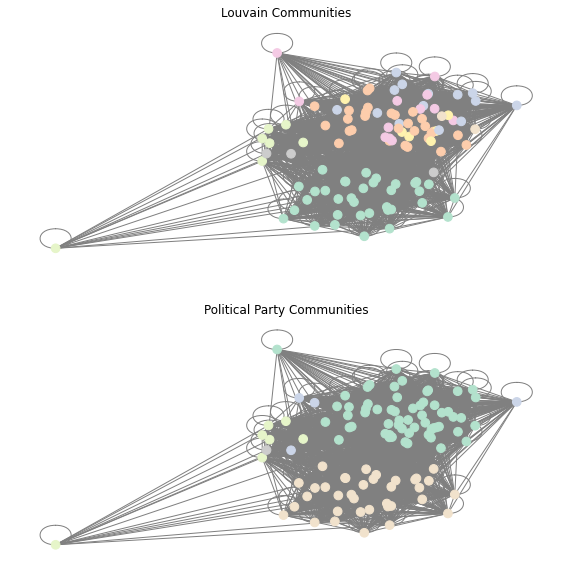

In [99]:
plt.figure(figsize=(10,10))

# plot louvain
graph = ontariopol
communities = louvain.to_node_community_map()
communities = [communities[k].pop() for k in graph.nodes]
pastel2 = cm.get_cmap('Pastel2', max(communities) + 1)

plt.subplot(211)
np.random.seed(123)
plt.title("Louvain Communities")
nx.draw_spring(graph, with_labels = False, cmap = pastel2,
               node_shape = '.',
               node_color = communities, edge_color = "grey")

# plot political party
atr = {k:j for (j,i) in enumerate(pol_comm) for k in i}
atr = [atr[k] for k in graph.nodes]
pastel2 = cm.get_cmap('Pastel2', max(atr) + 1)

plt.subplot(212)
np.random.seed(123)
plt.title('Political Party Communities')
nx.draw_spring(graph, with_labels = False, cmap = pastel2,
               node_shape = '.',
               node_color = atr, edge_color = "grey")

We see very similar community structures, indicating that the Louvain algorithm has done a good job of identifying political party alignment from the tweet activity of the politicians. 

We can also identify large cliques within the political parties.

In [80]:
# find largest clique
graph = ontariopol
max_clique_len = max(map(len, list(nx.find_cliques(graph))))
len([i for i in list(nx.find_cliques(graph)) if len(i) == max_clique_len])

24

There are 24 largest cliques with size of 48 nodes

In [122]:
pastel2(0)

(0.7019607843137254, 0.8862745098039215, 0.803921568627451, 1.0)

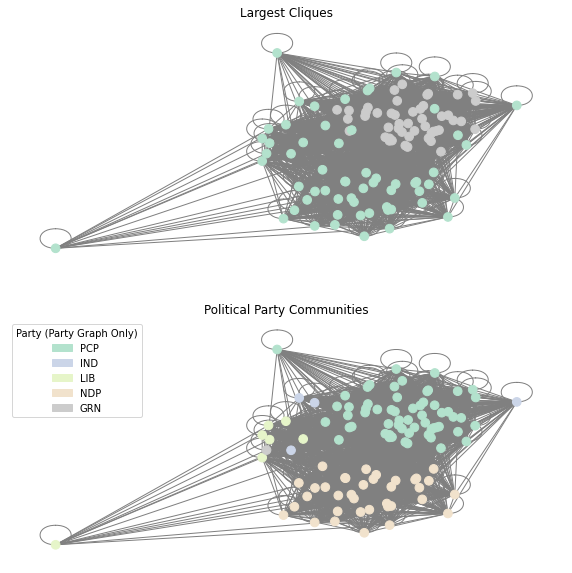

In [126]:
plt.figure(figsize=(10,10))

# plot largest cliques[0]
clique0 = [i for i in list(nx.find_cliques(graph)) if len(i) == max_clique_len][0]
atr = [1 if i in clique0 else 0 for i in graph.nodes]
pastel2 = cm.get_cmap('Pastel2', max(atr) + 1)

plt.subplot(211)
np.random.seed(123)
plt.title('Largest Cliques')
nx.draw_spring(graph, with_labels = False, cmap = pastel2,
               node_shape = '.',
               node_color = atr, edge_color = "grey")

# plot political party
atr = {k:j for (j,i) in enumerate(pol_comm) for k in i}
atr = [atr[k] for k in graph.nodes]
pastel2 = cm.get_cmap('Pastel2', max(atr) + 1)

plt.subplot(212)
np.random.seed(123)
plt.title('Political Party Communities')
nx.draw_spring(graph, with_labels = False, cmap = pastel2,
               node_shape = '.',
               node_color = atr, edge_color = "grey")

# draw legend
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=pastel2(i), label=j) 
           for i,j in zip(range(max(atr)+1), df_attr['party'].unique())]
plt.legend(handles=patches, title='Party (Party Graph Only)')

Comparison to party membership reveals this to be a PCP clique